# Regression project: Real Estate Assessment Evaluation
Home valuation is key in real estate industry, and also the basis for mortgages in credit sector. Here we have to predict the estimated value of a property.

Data (RegressionSupervisedTrain.csv) consist of a list of features plus the resulting "parcelvalue", described in "Casedatadictionary.xlsx" file. Each row corresponds to a particular home valuation, and "transactiondate" is the date when the property was effectively sold. Properties are defined by "lotid", but be aware that one property can be sold more than once (it's not the usual case). Also notice that some features are sometimes missing, your model has to deal with it.

Note that you should not use "totaltaxvalue", "buildvalue" or "landvalue", because they are closely correlated with the final value to predict. There is a further member of the training set predictors which is not available in the test set and therefore needs removing. Using this data build a predictive model for "parcelvalue"

In your analysis, use the RMSE (Root Mean Squared Error) criterion for choosing any hyperparameters. Try a first quick implementation, then try to optimize hyperparameters.

For this analysis there is an extra test dataset. Once your code is submitted we will run a competition to see how you score in the test data. Hence, have prepared also the necessary script to compute the MSE estimate on the test data once released.
Bonus: Try an approach to fill NA without removing features or observations, and check improvements.

You can follow those steps in your first implementation:
* Explore and understand the dataset. Report missing data
* Remove columns 'totaltaxvalue', 'buildvalue' or 'landvalue' from the training and testing set and also 'mypointer' from the training set
* As a simplified initial version, get rid of missing data by:
    - Removing features that have more than 40% of missing data in the training set (remember anything you remove from the training set must be removed form the testing set!) (HINT: data.dropna(axis=1, thresh=round(mypercentagevalid*len(data.index)) - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)
    - After that, removing observations that have missing data
* Create dummy variables for relevant categorical features (EXTENDED PROJECT ONLY)
* Build your model and test it on the same input data
* Assess expected accuracy using cross-validation
* Report which variable impacts more on results
* Prepare the code to run on a new input file and be able to report accuracy, following same preparation steps (missing data, dummies, etc)

Note that you should not use *totaltaxvalue*, *buildvalue *or *landvalue*, because they are closely correlated with the final value to predict.

You may want to iterate to refine some of these steps once you get performance results in step 5.

# 0. INITATE WORKSPACE

## 0.1 Import Libraries

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
from scipy.stats import skew
import geopandas as gpd
from shapely.geometry import Point

# Sklearn
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

# Visualisation
import plotly_express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Basic functions

## Log transformation
def log_transform(x):
    #print(x)
    return np.log(x + 1)


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## 0.2 Load in Data

In [226]:
train = pd.read_csv("/Users/gnlm/Desktop/housingprices/data/Regression_Supervised_Train.csv")
test = pd.read_csv("/Users/gnlm/Desktop/housingprices/data/Regression_Supervised_Test.csv")
print(f"Training:{train.shape}, \n Test:{test.shape}")

Training:(24755, 48), 
 Test:(2746, 46)


## 0.3 Basic Preprocessing
According to instructions

In [227]:
# Drop these features according to the instructions. mypointer is only present in the training set, so is dropped
drop_train = ['buildvalue', 'landvalue', 'mypointer', 'logerror', 'totaltaxvalue']
drop_test = ['buildvalue', 'landvalue', 'logerror', 'totaltaxvalue']

train = train.drop(drop_train, axis = 1)
test = test.drop(drop_test, axis = 1)
print(f"Training:{train.shape}, \n Test:{test.shape}")

Training:(24755, 43), 
 Test:(2746, 42)


# 1. EDA

## 1.1 Missing Values

In [133]:
percent_missing_train = train.isnull().sum() * 100 / len(train)
percent_missing_test = test.isnull().sum() * 100 / len(test)
missing_value_df = pd.DataFrame({
                                 'data_type':train.dtypes,
                                 'percent_missing_train': percent_missing_train,
                                      'percent_missing_test':percent_missing_test})
missing_value_df.sort_values(by = 'percent_missing_train', ascending = False)

data_type  percent_missing_train  percent_missing_test
perimeterarea        float64             100.000000            100.000000
classbuild           float64              99.927287            100.000000
basement             float64              99.773783            100.000000
storytype            float64              99.773783            100.000000
totalarea            float64              99.749546            100.000000
fireplace             object              99.240557             99.854334
style                float64              99.058776             99.963583
material             float64              98.994143             99.927167
decktype             float64              97.123813            100.000000
taxdelinquencyflag    object              96.420925             94.573926
taxdelinquencyyear   float64              96.420925             94.573926
poolarea             float64              95.128257            100.000000
tubflag               object              94.970713             98.579752
transactiondate       object              92.878206             93.627094
num34bath            float64              79.725308             99.745084
finishedarea1st      float64              75.184811            100.000000
finishedareaEntry    float64              75.184811            100.000000
numstories           float64              61.082610             99.380918
garagearea           float64              59.628358             99.344501
garagenum            float64              59.628358             99.344501
poolnum              float64              48.612402             41.077932
aircond              float64              41.571400             19.155135
qualitybuild         float64              40.803878              1.383831
unitnum              float64              40.371642              0.691916
neighborhoodcode     float64              39.297112              0.000000
heatingtype          float64              36.218946              0.000000
lotarea              float64               2.864068              0.000000
finishedarea         float64               0.254494              0.000000
numfullbath          float64               0.145425              0.000000
citycode             float64               0.125227              0.000000
year                 float64               0.048475              0.000000
regioncode           float64               0.008079              0.000000
roomnum                int64               0.000000              0.000000
parcelvalue          float64               0.000000                   NaN
numfireplace           int64               0.000000              0.000000
numbedroom             int64               0.000000              0.000000
lotid                  int64               0.000000              0.000000
taxyear                int64               0.000000              0.000000
longitude              int64               0.000000              0.000000
latitude               int64               0.000000              0.000000
countycode2            int64               0.000000              0.000000
countycode             int64               0.000000              0.000000
numbath              float64               0.000000              0.000000

## 1.1.1 Handling Missing Data
The data set has many features with missing values. I use the following rules to deal with them:
#### 1. For features with $>$ 40\% missing observations and no intuitive way of inferring, I drop them.
perimeterarea - drop
classbuild - drop
storytype - drop
totalarea - drop
style - drop
material - drop
finishedarea1st - drop feature
transaction date - drop; No information on this feature

#### 2. For the following features, NAN most likely means that the feature is not present. For eg, missing observation of poolnum is most likely that there are no pools in the house; such observations have the corresponding poolarea as missing too. Hence, I impute 0/False/N for such features.
basement - missing is 0
unitnum - missing is 0
dectype - missing is 0
taxdelinquencyyear - make it to zero
num34bath - missing is 0
garagearea - make it zero
pool area - make it zero
gargenum - missing is 0, drop feature
poolnum - missing is 0, drop feature
tubflag - missing is False
fireplace - missing is False
taxdelinquencyflag - N if no delinquency

#### 3. The following features are imputed.
aircond - missing is not 0 as the dictionary has the option for None. Impute mode
quality - impute
unitnum - impute
heatingtype - missing is not 0 as the dictionary has the option for None. Impute mode
lotarea - impute
finishedarea - impute
numfullbath - impute
year - convert to age
totaltaxvalue - impute
finishedareaEntry - impute

#### 4. Will be dealt with later
regioncode - check later
neighbourhoodcode - check later
citycode - check later

Drop features that have too many missing values where meaningful inferences cannot be made.

In [228]:
drop = ['perimeterarea', 'classbuild', 'storytype', 'totalarea', 'style', 'material', 'transactiondate', 'finishedarea1st']
train = train.drop(drop, axis = 1)
test = test.drop(drop, axis = 1)
print(f"Training:{train.shape}, \n Test:{test.shape}")

Training:(24755, 35), 
 Test:(2746, 34)


When missing indicates absence of feature - code it as 0

In [229]:
impute_zero = ['basement',  'unitnum', 'decktype', 'num34bath', 'garagearea', 'poolarea', 'taxdelinquencyyear', 'garagenum', 'poolnum']
impute_false = ['fireplace', 'tubflag']
impute_no = ['taxdelinquencyflag']
present_year = 2020

for item in [train, test]:
    item[impute_zero] = item[impute_zero].fillna(0)
    item[impute_false] = item[impute_false].fillna(False)
    item[impute_no] = item[impute_no].fillna("N")
    # For these features, convert point in time to duration
    item['year'] = item['year'].apply(lambda x: present_year - x)
    item['taxyear'] = item['taxyear'].apply(lambda x: present_year - x)

## 2. EDA

Set numerical and categorical features

In [136]:
categorical = ['aircond', 'qualitybuild', 'decktype', 'tubflag', 'heatingtype', 'fireplace', 'taxdelinquencyflag', 'countycode', 'countycode2', 'regioncode', 'neighborhoodcode', 'citycode', 'lotid']
numerical = ['basement', 'numbath', 'numbedroom', 'finishedarea', 'finishedareaEntry', 'numfireplace', 'numfullbath', 'garagenum', 'garagearea', 'lotarea', 'poolnum', 'poolarea', 'roomnum', 'num34bath', 'unitnum', 'year', 'numstories', 'taxyear', 'taxdelinquencyyear', 'latitude', 'longitude' ]

### 2.1 Skew

Skew of target feature 10.924666213432062
Skew of target feature after log transformation 0.12866162749355226


Text(0.5, 1.0, 'Log(Parcelvalue)')

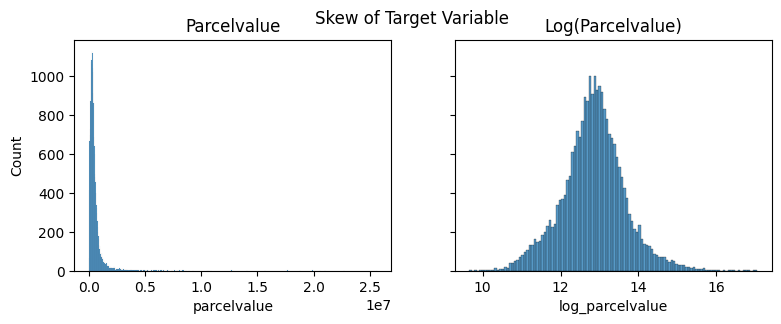

In [231]:
# Calculate skew
print(f"Skew of target feature {skew(train.parcelvalue)}") # 10.924666213432062

# The target has a positive skew. Log transform the variable to get a more symmetrical distribution
train['log_parcelvalue'] = np.log(train['parcelvalue'])

# Calculate skew and visualize
print(f"Skew of target feature after log transformation {skew(train.log_parcelvalue)}")

# Histograms
fig, axes = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
fig.suptitle('Skew of Target Variable')
## Original
sns.histplot(ax=axes[0], x = train.parcelvalue)
axes[0].set_title('Parcelvalue')
## Log transformed
sns.histplot(ax=axes[1], x = train.log_parcelvalue)
axes[1].set_title('Log(Parcelvalue)')

Skew of numerical features. 12 out of 19 features have a skew greater than 1. Hence, it is best to log transform all numerical features

In [138]:
# Calculate skew
skew_df = pd.DataFrame(train[numerical].skew(skipna = True)).abs()
print(f"% Features with skew greater than 1 is {skew_df[skew_df[0] > 1]}")

% Features with skew greater than 1 is                             0
basement            34.786710
numbath              1.700750
finishedarea         3.534346
finishedareaEntry    3.140212
numfireplace         2.423594
numfullbath          1.726680
garagenum            1.187571
garagearea           1.585248
lotarea             10.063577
poolarea             4.837032
num34bath            1.655079
taxdelinquencyyear   5.081086


### 2.2 Scatter Plots
Now I look at the joint distribution of the features and target variable. Since the task is to use linear regression, I also fit the OLS line of best fit with $CI = 95\%$

### Scatter plot with ols line of best fit, $CI = 95\%$


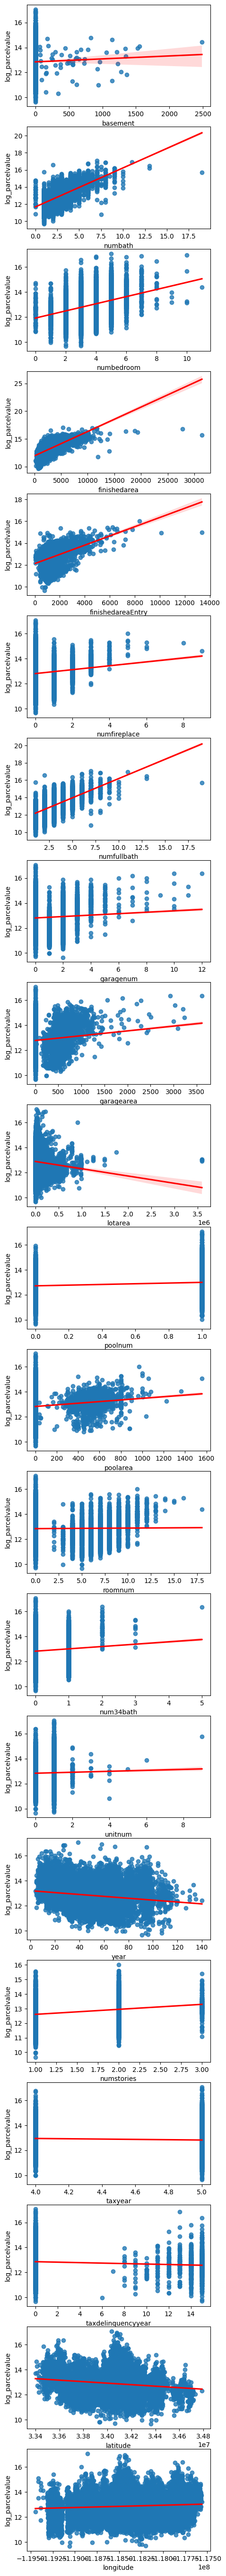

In [27]:
fig, axes = plt.subplots(len(numerical), 1, figsize=(5, 70))
i = 0
for feat in numerical:
    sns.regplot(ax = axes[i], x = train[feat], y= train['log_parcelvalue'], ci = 95, line_kws = {'color':'red'})
    i += 1

Most features do exhibit a linear relationship.
Notes:
1. It doesn't make sense to treat longitude and latitude as affecting the target in a linear manner. I will use a clustering algorithm and use the cluster labels instead of lat/long in the model.
2. 'year' and 'lotarea' do not seem to have a linear relationship with the target. Might consider dropping these variables when trying to improve the model.

## 2.2 Correlations
Here I plot the correlation heatmap for all features

<AxesSubplot: >

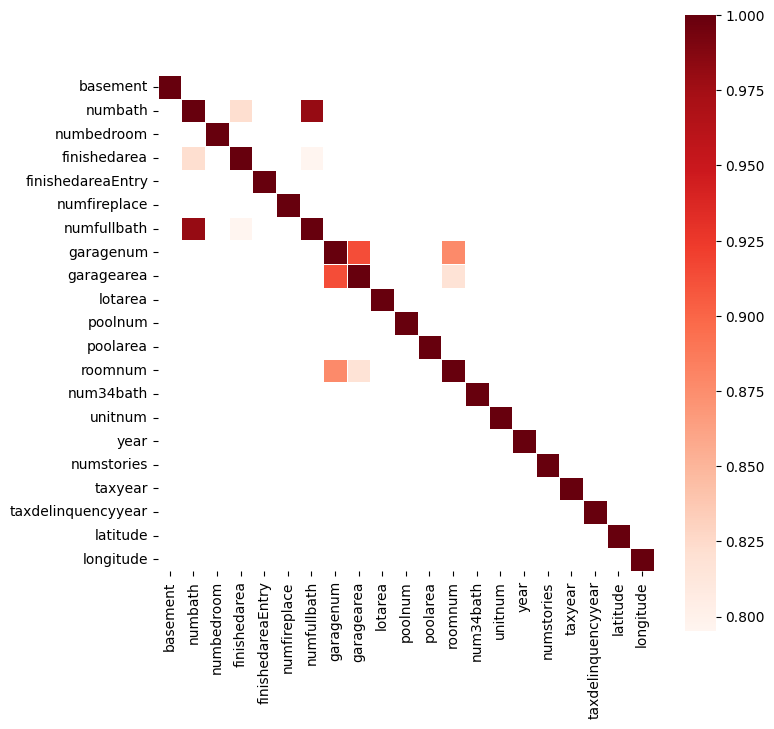

In [28]:
correlation_matrix = train[numerical].corr()
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(correlation_matrix, mask = correlation_matrix < 0.75, linewidth = 0.5, cmap = 'Reds', square = True)

Highly correlated variables are (numfullbath, numbath), (garagenum, garagearea), (roomnum, garagenum), (roomnum, garagearea), (finishedarea, numbath), (finishedarea, numfullbath). I will look into dropping certain features after the first fit of the model. Dropping numfullbath and num34bath might be benefical as numbath captures these 2 features.



## 2.3 Cardinality
Citycode, regioncode and neighborhood code have high cardinality.
Lotid is not unique $\implies$ houses have been sold more than once. Can be considered in feature engineering

In [29]:
for feature in categorical:
    print(feature,":", train[feature].nunique())

aircond : 6
qualitybuild : 10
decktype : 2
tubflag : 2
heatingtype : 11
fireplace : 2
taxdelinquencyflag : 2
countycode : 3
countycode2 : 3
regioncode : 371
neighborhoodcode : 453
citycode : 154
lotid : 24622


Visualise boxplot of houses sold more than once. Houses sold more than once seem to have fewer outliers and a more compact distribution.

<AxesSubplot: xlabel='resold', ylabel='log_parcelvalue'>

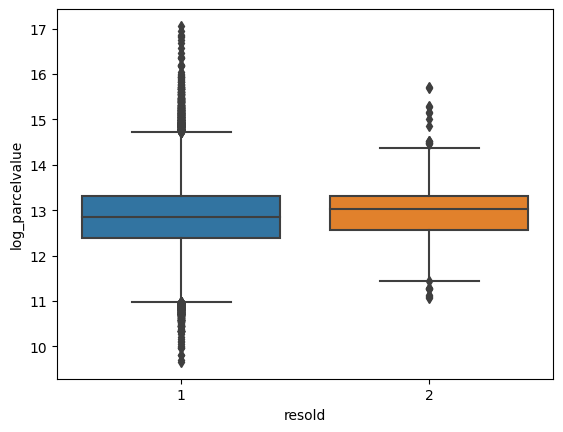

In [232]:
# Create column if house is resold more than once
train['resold'] = train['lotid'].map(train['lotid'].value_counts())
test['resold'] = test['lotid'].map(test['lotid'].value_counts())

# Vissualize
sns.boxplot(train, x = 'resold', y = 'log_parcelvalue')

# 3. FEATURE ENGINEERING

### 3.1 Longitude & Latitude
For linear models, it does not make sense to use the longitude and latitude directly. Hence, I use a clustering method to cluster houses based on the coordinates. Using K-means, I find the optimal $K = 5$

In [233]:
# Latitude and longitude are multiplied by $10^6$ in the datasets
for item in [train, test]:
    item['longitude'] = item['longitude']/10**6
    item['latitude'] = item['latitude']/10**6

Visualise the coordinates

/Users/gnlm/Desktop/housingprices/venv/Desktop/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Text(0.5, 1.0, 'Los Angeles, Ventura & Orange Counties: Real Estate')

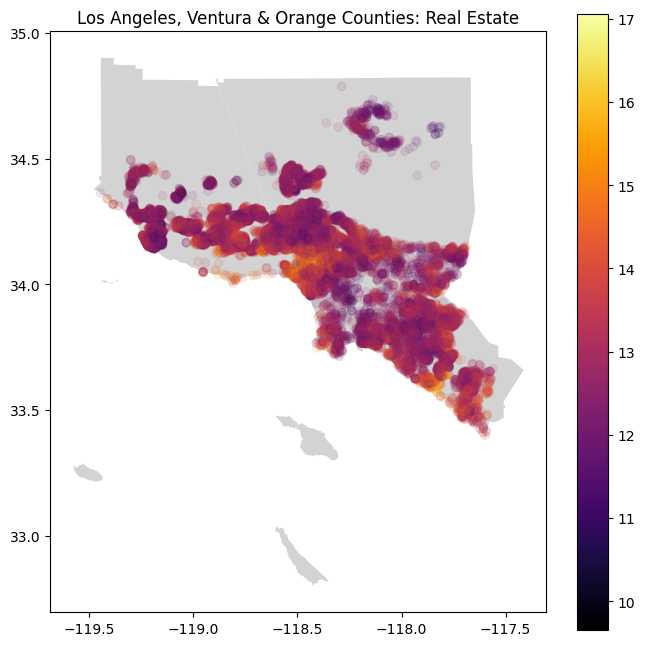

In [63]:
# Load the county map. County map downloaded from https://gis.data.ca.gov/datasets/8713ced9b78a4abb97dc130a691a8695_0/explore?filters=eyJDT1VOVFlfTkFNRSI6WyJMb3MgQW5nZWxlcyJdfQ%3D%3D&location=34.524112%2C-117.443958%2C6.94
cali_map = gpd.read_file("/Users/gnlm/Desktop/housingprices/data/California_County_Boundaries/cnty19_1.shp")

# Get subset of training data
geo_data = train[['log_parcelvalue', 'latitude', 'longitude']]

# Declare CRS
crs = {'init': 'epsg:4326'}

# Create geometry points using lat and long
geometry = [Point(xy) for xy in zip(geo_data['longitude'], geo_data['latitude'])]

# Make a geographic dataframe
geo_df = gpd.GeoDataFrame(geo_data,
                          crs = crs,
                          geometry = geometry)

# Plot the houses on the county map
fig, ax = plt.subplots(figsize = (8, 8))
cali_map.to_crs(epsg=4326).plot(ax = ax, color = 'lightgrey')
geo_df.plot(ax = ax, alpha = 0.1, column = 'log_parcelvalue', legend = True, cmap = 'inferno')
ax.set_title('Los Angeles, Ventura & Orange Counties: Real Estate')

K-Means Clustering
Using the elbow method, I choose $K=5$

In [9]:
# Search over K = 1 to K = 10
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = train[['latitude']]
X_axis = train[['longitude']]

# Fit the K-Means and store the scores
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

# Visualize
fig = px.line(y = score, x = K_clusters)
fig.add_vline(x = 5,
              line_color = "red",
              annotation_text = 'Marginal Decrease after K = 5',
              annotation_position = 'top right')

Fit the KMeans clustering on the training and predict clusters on the train and test sets.

<AxesSubplot: xlabel='latitude', ylabel='longitude'>

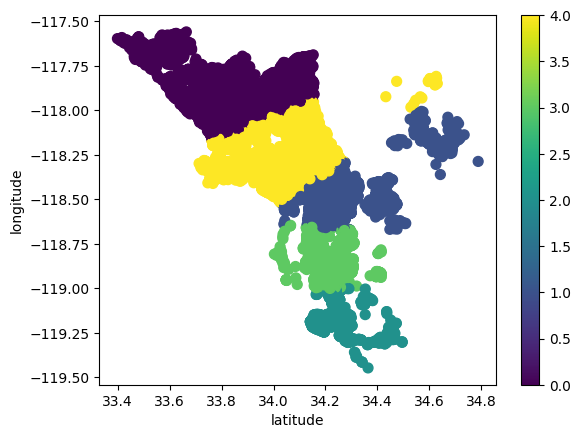

In [234]:
# Initiate KMeans
kmeans = KMeans(n_clusters = 5, init ='k-means++')

# Fit on training set
kmeans.fit(train[['longitude', 'latitude']]) # Compute k-means clustering.

# Predict on train and test sets
train['cluster_label'] = kmeans.fit_predict(train[['longitude', 'latitude']])
test['cluster_label'] = kmeans.predict(test[['longitude', 'latitude']])

for df in [train, test]:
    df['cluster_label'] = df['cluster_label'].astype("category")

# Coordinates of cluster centers
centers = kmeans.cluster_centers_
labels = kmeans.predict(train[['longitude', 'latitude']])

# Visualize clusters
train.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')

## 3.2 Creating New Features
I create the following features. These are mere subjective assessments of "relevant" features.

1. $Average\ room\ size = (Total\ finished\ area)/(# Bedrooms)$
2. $Bed-Bathroom-Ratio = (# Bathrooms)/(# Bedrooms )$

Text(0.5, 1.0, 'Bed-Bath Ratio')

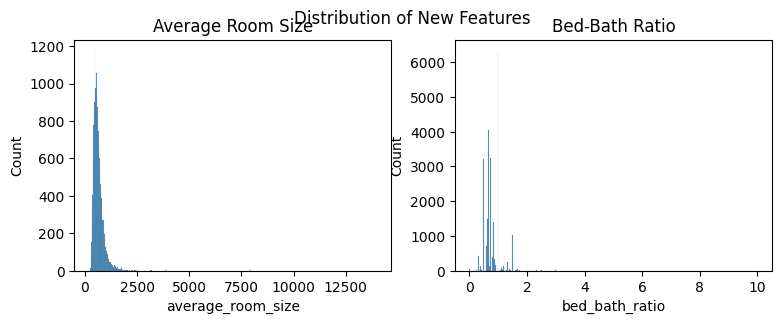

In [235]:
for df in [train, test]:
    df['average_room_size'] = np.where(df['numbedroom'] > 0, df['finishedarea']/df['numbedroom'], df['finishedarea'])
    # Number of bathrooms per bedroom
    df['bed_bath_ratio'] = np.where(df['numbedroom'] > 0, df['numbath']/df['numbedroom'], df['numbath']) 
new_features = ['average_room_size', 'bed_bath_ratio']

# Histograms
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
fig.suptitle('Distribution of New Features')
## Original
sns.histplot(ax=axes[0], x = train.average_room_size)
axes[0].set_title('Average Room Size')
## Log transformed
sns.histplot(ax=axes[1], x = train.bed_bath_ratio)
axes[1].set_title('Bed-Bath Ratio')

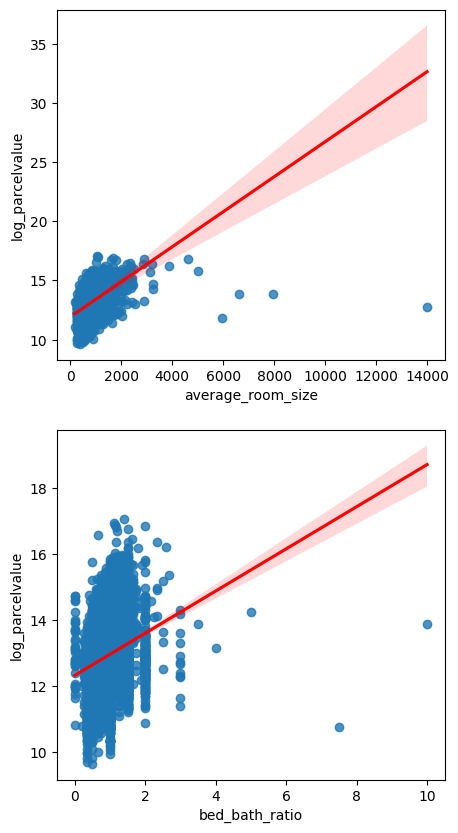

In [254]:
# Regplot of new features
fig, axes = plt.subplots(len(new_features), 1, figsize=(5, 10))
i = 0
for feat in new_features:
    sns.regplot(ax = axes[i], x = train[feat], y= train['log_parcelvalue'], ci = 95, line_kws = {'color':'red'})
    i += 1

# 4. FITTING THE MODEL


Create target and feature dataframes

In [236]:
# lotid is a identity feature, conveys no meaningful information. I will use the resale feature created
# Longitude and latitude have been dealt with.
# numfullbath and num34bath add up to numbath. To avoid high correlated features, I only keep numbath

X_simple = train.drop(['parcelvalue', 'lotid', 'log_parcelvalue', 'longitude', 'latitude', 'numfullbath', 'num34bath', 'average_room_size', 'bed_bath_ratio', 'resold', 'taxdelinquencyflag', 'neighborhoodcode', 'citycode'], axis = 1)
y = train['log_parcelvalue']
print(f"Features:{X_simple.shape}, \n Target:{y.shape}")

Features:(24755, 27), 
 Target:(24755,)


Make lists of categorical and numerical features: I first start without new_features and city and neighbourhood codes.

In [237]:
categorical = ['aircond', 'qualitybuild', 'decktype', 'tubflag', 'heatingtype', 'fireplace', 'cluster_label', 'countycode', 'regioncode', 'countycode2']
numerical = ['basement', 'numfireplace', 'garagenum', 'garagearea', 'lotarea', 'poolarea', 'roomnum', 'unitnum', 'year', 'taxdelinquencyyear', 'taxyear', 'numstories', 'poolnum', 'finishedarea', 'numbath', 'numbedroom', 'finishedareaEntry']

Note:
Performing log transformation before polynomial yields a better score on the test set
log 1st -  540024.94634
poly 1st - 582619.71501

## 4.1 Regression Pipeline

In [252]:
log_tranformer = FunctionTransformer(log_transform)

numeric_transformer = Pipeline(
             steps = [
                      ("imputer", SimpleImputer(strategy = 'median')),
                      ("log", log_tranformer),
                      ("poly", PolynomialFeatures(degree = 3)),
                      ("scaler", StandardScaler())
                      ])

categorical_transformer = Pipeline(
             steps = [ ("imputer", SimpleImputer(strategy = "most_frequent")),
                        ( "ohe", OneHotEncoder(handle_unknown='ignore', sparse=False))])

# preprocessor pipeline combining both:
preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, numerical),
        ("cat", categorical_transformer, categorical),
        ])

# Define the pipeline for preprocessing and the classifier.
regression_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regression', LinearRegression())])

# Check structure of pipeline:
regression_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log',
                                                                   FunctionTransformer(func=<function log_transform at 0x1049dc820>)),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['basement', 'numfireplace',
                                                   'garagenum', 'garagearea',
                                                   'lotarea', 'poolarea',
                                                   'roomn...
                                                   'numbath', 'numbedroom',
                                                   'finishedareaEntry']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['aircond', 'qualitybuild',
                                                   'decktype', 'tubflag',
                                                   'heatingtype', 'fireplace',
                                                   'cluster_label',
                                                   'countycode', 'regioncode',
                                                   'countycode2'])])),
                ('regression', LinearRegression())])

### 4.1.1 In-sample Performance
The cross-validated predictions have some outliers, hence the high score. Not sure why this is happening as predicting without CVP does not have this issue.

In [87]:
# Get cross validated predictions
y_hat_in = cross_val_predict(regression_pipeline, X_simple, y, cv = 10)

# Check in sample RMSE
print(f"RMSE = {mean_squared_error(y, y_hat_in, squared = False)}")

RMSE = 10296307812.061443


### 4.1.2 Test-sample Performance: Private Score on Kaggle = 523533

In [253]:
# Fit model
regression_pipeline.fit(X_simple, y)

# Predict on test set and undo the logarithmic transformation of target feature
y_hat_test = np.exp(regression_pipeline.predict(test[X_simple.columns]))

# Create datafram of predictions
test_predictions_submit = pd.DataFrame({"lotid": test["lotid"], "parcelvalue": y_hat_test})

# Dataframe to csv
test_predictions_submit.to_csv("test_predictions_linreg.csv", index = False)

## 4.2 Lasso
### 4.2.1 Lasso Pipeline

In [ ]:
# Define the pipeline for preprocessing and the classifier.
lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('Lasso', Lasso())])

# Check structure of pipeline:
lasso_pipeline

param_grid = {
                # 'Lasso__alpha' : [0.01, 0.1, 1, 10, 100], # 0.01 chosen
                'Lasso__alpha' : [0.001, 0.005, 0.01], # 0.001 chosen,
                #'Lasso__alpha' : [0.0001, 0.0005, 0.001]} # 0.001 chosen
                # 'Lasso__alpha' : [0.001, 0.002, 0.003],
                     } # 0.02 chosen, RMSE = 4.046044868414892
# Initiate grid search object
grid_search_lasso = GridSearchCV(lasso_pipeline,
                           param_grid,
                           cv = 10,
                           scoring = "neg_root_mean_squared_error",
                           verbose = 10)
# Fit the grid search
grid_search_lasso.fit(X_simple, y)

# Get best parameters
print(grid_search_lasso.best_params_)

# Get in sampple predictions and RMSE
y_hat_in_lasso = grid_search_lasso.predict(X_simple)

# Check in sample RMSE
print(f"RMSE = {mean_squared_error(y, y_hat_in_lasso, squared = False)}") # RMSE = 0.546596197015829 (log values)

### 4.2.1 Test-sample Performance: Private Score on Kaggle = 629499.66905

In [58]:
y_hat_test_lasso = np.exp(grid_search_lasso.predict(test[X_simple.columns]))
test_predictions_submit = pd.DataFrame({"lotid": test["lotid"], "parcelvalue": y_hat_test_lasso})
test_predictions_submit.to_csv("test_predictions_lasso.csv", index = False)

## 4.3 Ridge
### 4.3.1 Ridge Pipeline

Gridsearch returns $\alpha=10$ as the best parameter. However, $\alpha=0.1$ performs best on the test set.

In [ ]:
# Define the pipeline for preprocessing and the classifier.
ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('Ridge', Ridge())])

# Check structure of pipeline:
ridge_pipeline

param_grid = {
                'Ridge__alpha' : [0.01, 0.1, 1, 10, 100], # 10 chosen
                # 'Ridge__alpha' : [0.001, 0.005, 0.01], # 10 chosen
                #'Ridge__alpha' : [5, 8, 10, 15, 20, 25, 30] 10
                # 'Ridge__alpha' : [0.001, 0.002, 0.003],
                     } # 0.02 chosen, RMSE = 4.046044868414892
# Initiate grid search object
grid_search_ridge = GridSearchCV(ridge_pipeline,
                           param_grid,
                           cv=10,
                           scoring = "neg_root_mean_squared_error",
                           verbose = 10)
# Fit the grid search
grid_search_ridge.fit(X_simple, y)

# Get best parameters
print(grid_search_ridge.best_params_)

# Get in sampple predictions and RMSE
y_hat_in_ridge = grid_search_ridge.predict(X_simple)

# Check in sample RMSE
print(f"RMSE = {mean_squared_error(y, y_hat_in_ridge, squared = False)}") # RMSE = 0.5164723492805274 (log values)

### 4.3.2 Test-sample Performance: Private Score on Kaggle = 538,673

In [60]:
y_hat_test_ridge = np.exp(grid_search_ridge.predict(test[X_simple.columns]))
test_predictions_submit = pd.DataFrame({"lotid": test["lotid"], "parcelvalue": y_hat_test_ridge})
test_predictions_submit.to_csv("test_predictions_ridge.csv", index = False)

# 5. Improving the Model
Thus far, the Linear Regression model performs best in training and test scores. Now, I try some methods to see if the model improves
## 5.1 Removing Highly Correlated Features

In [ ]:
# Drop missing observations
X_low_corr = X_simple[numerical].dropna(axis = 0)

# Declare empty list to store features
correlated_features = []

# Get correlation matrix
correlation_matrix = X_low_corr.corr()

# Loop through correlation matrix and add columns with correlation higher than 0.8
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            feat_name = correlation_matrix.columns[i]
            correlated_features.append(feat_name)

# Use set to get unique elements
correlated_features = list(set(correlated_features))

print(f"Features to remove due to high correlation:{correlated_features}")

# Drop the correlated features
X_low_corr = X_simple.drop(correlated_features, axis = 1)

### 5.1.2 Pipeline & Performance
 Kaggle Score: 554,122
Model performs worse both in sample and test sets.

In [111]:
# Remove correlated features from the list
categorical = ['aircond', 'qualitybuild', 'decktype', 'tubflag', 'heatingtype', 'fireplace', 'cluster_label', 'countycode', 'regioncode', 'countycode2']
numerical = ['basement', 'numfireplace', 'garagenum', 'garagearea', 'lotarea', 'poolarea', 'roomnum', 'unitnum', 'year', 'taxdelinquencyyear', 'taxyear', 'numstories', 'finishedarea', 'numbedroom', 'finishedareaEntry']

# preprocessor pipeline combining both:
preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, numerical),
        ("cat", categorical_transformer, categorical),
        ])

# Define the pipeline for preprocessing and the classifier.
regression_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regression', LinearRegression())])
# Get cross validated predictions
y_hat_in = cross_val_predict(regression_pipeline, X_low_corr, y, cv = 5)

# Check in sample RMSE
print(f"RMSE = {mean_squared_error(y, y_hat_in, squared = False)}") #RMSE = 4205690032.6768684

# Fit model
regression_pipeline.fit(X_low_corr, y)

# Predict on test set and undo the logarithmic transformation of target feature
y_hat_test = np.exp(regression_pipeline.predict(test[X_low_corr.columns]))

# Create datafram of predictions
test_predictions_submit = pd.DataFrame({"lotid": test["lotid"], "parcelvalue": y_hat_test})

# Dataframe to csv
test_predictions_submit.to_csv("test_predictions_linreg_lowcorr.csv", index = False)

RMSE = 18501932543.680576


## 5.2 Dealing With High Cardinality Features: neighborhoodcode and citycode
For high cardinality features, it does not make sense to use them directly. Maybe the character of neighborhoodcode and citycode denote the general area of the house. I test my hypothesis here:

In [180]:
for df in [train, test]:
    df['citycode_small'] = df['citycode'].apply(lambda x: str(x)[:1] if not np.isnan(x) else x )
    df['neighborhoodcode_small'] = df['neighborhoodcode'].apply(lambda x: str(x)[:1] if not np.isnan(x) else x )

### 5.2.1 Visualize New Features
There does not seem to be any clear trend between the new features and the target.

Text(0.5, 1.0, 'Neighborhoodcode')

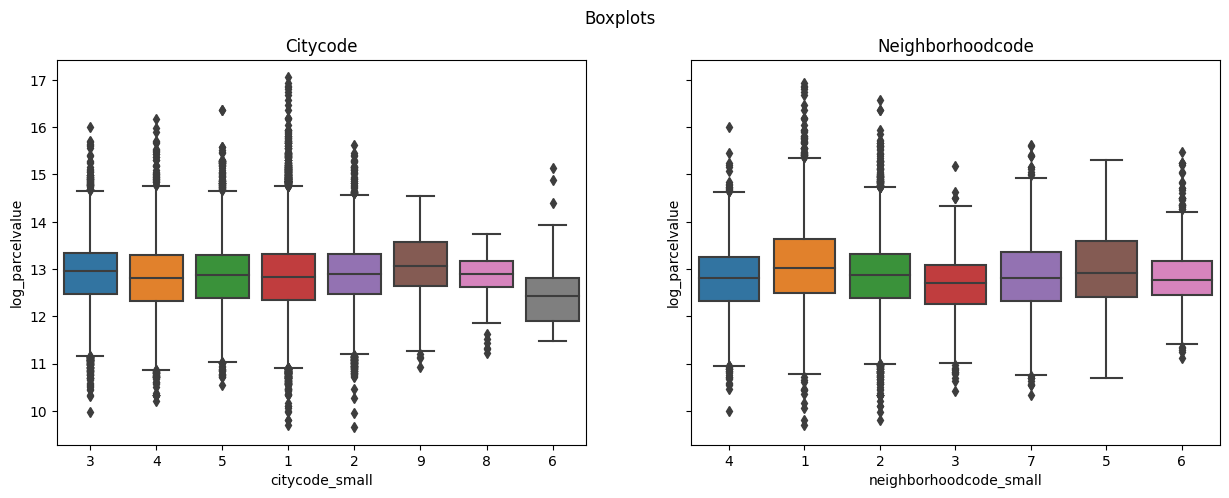

In [183]:
# Boxplots for new features
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Boxplots')
## Original
sns.boxplot(ax=axes[0], x = train.citycode_small, y = train.log_parcelvalue)
axes[0].set_title('Citycode')
## Log transformed
sns.boxplot(ax=axes[1], x = train.neighborhoodcode_small, y = train.log_parcelvalue)
axes[1].set_title('Neighborhoodcode')

In [210]:
X = train.drop(['parcelvalue', 'lotid', 'log_parcelvalue', 'longitude', 'latitude', 'numfullbath', 'num34bath', 'average_room_size', 'bed_bath_ratio', 'resold', 'taxdelinquencyflag', 'neighborhoodcode', 'citycode'], axis = 1)
y = train['log_parcelvalue']
print(f"Features:{X_simple.shape}, \n Target:{y.shape}")

Features:(24755, 27), 
 Target:(24755,)


### 5.2.2 Pipeline & Performance
In-sample: 12800268294
Kaggle Score: 546838

In [214]:
# Redefine categorical and numerical variables
categorical = ['aircond', 'qualitybuild', 'decktype', 'tubflag', 'heatingtype', 'fireplace', 'cluster_label', 'countycode', 'regioncode', 'countycode2', 'citycode_small', 'neighborhoodcode_small']
numerical = ['basement', 'numfireplace', 'garagenum', 'garagearea', 'lotarea', 'poolarea', 'roomnum', 'unitnum', 'year', 'taxdelinquencyyear', 'taxyear', 'numstories', 'finishedarea', 'numbedroom', 'finishedareaEntry']

# Get cross validated predictions
y_hat_in = cross_val_predict(regression_pipeline, X, y, cv = 5)

# Check in sample RMSE
print(f"RMSE = {mean_squared_error(np.log(y), y_hat_in, squared = False)}") #RMSE = 12800268294.513073

# Fit model
regression_pipeline.fit(X, y)

# Predict on test set and undo the logarithmic transformation of target feature
y_hat_test = np.exp(regression_pipeline.predict(test[X.columns]))

# Create datafram of predictions
test_predictions_submit = pd.DataFrame({"lotid": test["lotid"], "parcelvalue": y_hat_test})

# Dataframe to csv
test_predictions_submit.to_csv("test_predictions_linreg_str.csv", index = False) #532418.61426

RMSE = 12800268294.513073


## 5.3 Use All Features

In [215]:
X = train.drop(['parcelvalue', 'lotid', 'log_parcelvalue', 'longitude', 'latitude', 'numfullbath', 'num34bath', 'finishedareaEntry', 'taxdelinquencyflag',
                'citycode', 'neighborhoodcode'], axis = 1)
y = train['log_parcelvalue']

### 5.3.1 Pipeline & Performance:
In-Sample Score: 13415939472
Kaggle Score: 560339

In [218]:
categorical = ['aircond', 'qualitybuild', 'decktype', 'tubflag', 'heatingtype', 'citycode_small', 'neighborhoodcode_small', 'countycode', 'countycode2', 'regioncode',  'fireplace', 'cluster_label', 'resold' ]
numerical = ['basement', 'numbath', 'numbedroom',  'finishedarea', 'numfireplace', 'garagenum', 'garagearea', 'lotarea', 'poolnum', 'poolarea', 'roomnum', 'unitnum', 'year', 'numstories', 'taxyear', 'taxdelinquencyyear', 'average_room_size', 'bed_bath_ratio']

# Get cross validated predictions
y_hat_in = cross_val_predict(regression_pipeline, X, y, cv = 5)

# Check in sample RMSE
print(f"RMSE = {mean_squared_error(np.log(y), y_hat_in, squared = False)}")

# Fit model
regression_pipeline.fit(X, y)

# Predict on test set and undo the logarithmic transformation of target feature
y_hat_test = np.exp(regression_pipeline.predict(test[X.columns]))

# Create datafram of predictions
test_predictions_submit = pd.DataFrame({"lotid": test["lotid"], "parcelvalue": y_hat_test})

# Dataframe to csv
test_predictions_submit.to_csv("test_predictions_linreg_allfeats.csv", index = False)

# 6. Feature Importance
## 6.1 Obtain Coefficients From Pipeline


In [268]:
# Numerical transformer feature names
num_list = regression_pipeline['preprocessor'].named_transformers_["num"]['poly'].get_feature_names_out().tolist()
# OneHot feature names
ohe_list = regression_pipeline["preprocessor"].named_transformers_["cat"].get_feature_names_out().tolist()
# Concatenate all the lists
feat_list = [*num_list, *ohe_list]

# Check list shape
len(feat_list)

# Coefficient list
c1 = regression_pipeline['regression'].coef_
# Flatten list
# coeffs = [item for sublist in c1 for item in sublist]

# Make dictionary of features and coefficients
coef_dict = {}
for coef, feat in zip(c1, feat_list):
    coef_dict[feat] = coef

## 6.2 Plot Coefficients
All of the top 5 coefficients are non-linear. Interpreting them is not straightforward.

([0, 1, 2, 3, 4],
 [Text(0, 0, 'x7 x10'),
  Text(1, 0, 'x3 x10'),
  Text(2, 0, 'x7 x10^2'),
  Text(3, 0, 'x7 x14 x16'),
  Text(4, 0, 'x7 x14')])

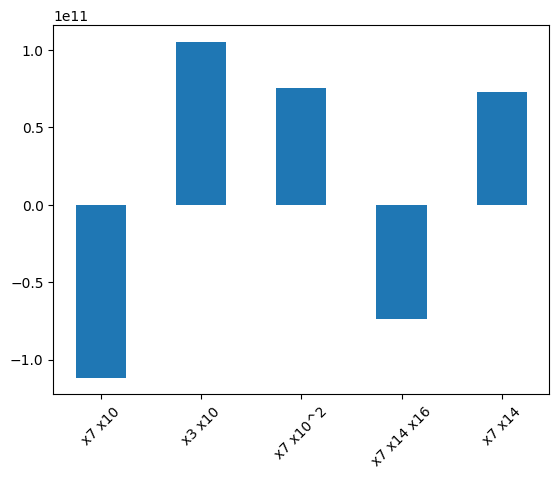

In [269]:
# Sort dictionary
sorted_dict = dict(sorted(coef_dict.items(),
                          key=lambda item: abs(item[1]),
                          reverse = True))
# Get list of feature-coeff pair
feat_imp = list(sorted_dict.items())[:5]
# Flatten list
feat, coef = zip(*feat_imp)

# Plot the features
plt.bar(feat, coef, width = 0.5)
plt.xticks(rotation = 45)

# 7. Conclusion
1. The Linear Regression model performs best for this task compared to Lasso and Ridge.
2. Feature engineering and creating new features did not improve the model. In fact, simpler models performed better compared to complex ones.
3. Most important features i.e. biggest coefficients are for non-linear features.